# Question 7 [Discriminative vs Generative Models, 25 Marks]

In [1]:
library(ggplot2)
library(reshape2)
library(mvtnorm)


Warning message:
"package 'ggplot2' was built under R version 4.0.2"


### 7.1 
##### Load Task1E_train.csv and Task1E_test.csv as well as the Bayesianclassifier (BC) and logistic regression (LR) codes from Activities 3.2 and 3.3in Module 3.

In [2]:
train = read.csv('Data_set/Task1E_train.csv')
train_data = train[1:2]
train_label = train[3]

test = read.csv('Data_set/Task1E_test.csv')
test_data = test[1:2]
test_label = test[3]

##### Bayesian classifier

In [3]:
error = function(prediction, label){
    sum(prediction != label) / length(label)
}

In [4]:
bayesian_classifier = function(train_data, train_label, test_data, test_label){
    p0_hat = sum(train_label==1)/nrow(train_data)
    p1_hat = sum(train_label==-1)/nrow(train_data)
    
    mu0_hat = colMeans(train_data[train_label==1,])
    mu1_hat = colMeans(train_data[train_label==-1,])
    
    sigma0_hat = var(train_data[train_label==1,])
    sigma1_hat = var(train_data[train_label==-1,])
    
    sigma_hat = p0_hat * sigma0_hat + p1_hat * sigma1_hat
    
    posterior0 = p0_hat*dmvnorm(x=train_data, mean=mu0_hat, sigma=sigma_hat)
    posterior1 = p1_hat*dmvnorm(x=train_data, mean=mu1_hat, sigma=sigma_hat)
    
    train_predict = ifelse(posterior0 > posterior1, 1, -1)
    test_predict = ifelse(p0_hat*dmvnorm(x=test_data, mean=mu0_hat, sigma=sigma_hat) > p1_hat*dmvnorm(x=test_data, mean=mu1_hat, sigma=sigma_hat), 1, -1)
    #return (list(train.predict, test.predict))
    return (list("train"=error(train_predict, train_label), "test"=error(test_predict, test_label)))
}

##### Logistic regression (LR)

In [5]:
predict = function(w, X, c0, c1){
    sig = sigmoid(w, X)
    return(ifelse(sig>0.5, c1,c0))
}

cost = function (w, X, T, c0){
    sig = sigmoid(w, X)
    return(sum(ifelse(T==c0, -log(1-sig), -log(sig)))/nrow(X))
}

sigmoid = function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
}

In [6]:
logistic_regression =  function(train_data, train_label, test_data, test_label, eta=0.01, epsilon=0.01, tau_max=1000){
    X = as.matrix(train_data) # rename just for conviniance
    T = ifelse(train_label==1,0,1) # rename just for conviniance
    
    train_len = nrow(X)
    test_data = as.matrix(test_data) # rename just for conviniance
    test_label = ifelse(test_label==1,0,1) # rename just for conviniance

    W = matrix(,nrow=tau_max, ncol=(ncol(X)+1)) # to be used to store the estimated coefficients
    W[1,] = runif(ncol(W)) # initial weight (any better idea?)
    Y = sigmoid(W[1,],X)
    tau = 1
    terminate = FALSE
    while(!terminate){
        terminate = tau >= tau_max  | cost(W[tau,],X,T, 0)<=epsilon
        train_index = sample(1:train_len, train_len, replace = FALSE)
        X = X[train_index,]
        T = T[train_index]
        
        # for each datapoint:
        for (i in 1:train_len){
            # check termination criteria:
            if (tau >= tau_max | cost(W[tau,],X,T, 0) <=epsilon) {terminate<-TRUE;break}

            Y <- sigmoid(W[tau,],X)

            # Update the weights
            W[(tau+1),] <- W[tau,] - eta * (Y[i]-T[i]) * cbind(1, t(X[i,]))

            # update the counter:
            tau <- tau + 1

            # decrease learning rate:
            eta = eta * 0.999
        }
    }  
    w = W[tau,]
    train_cost = cost(w, X, T, 0)
    test_cost = cost(w, test_data, test_label, 0)
    return(list("W"=w, "train"=train_cost, "test"=test_cost))
}

### 7.2
##### Using the first 5 data points from the training set, train a BC anda LR model, and compute their training and testing errors. In a “for loop”,increase the size of training set (5 data points at a time), retrain the modelsand calculate their training and testing errors until all training data pointsare used. In one figure, plot the training errors of the BC and LR models(with different colors) versus the size of the training set and in the otherfigure, plot the testing errors of the BC and LR models(with different colors) versus the size of the training set; include two plots in your Jupyter Notebook file for Question 7.

In [7]:
train_errors = data.frame("batch"=seq(5, nrow(train_data), by=5), "lr"=0, "bc"=0)
test_errors = data.frame("batch"=seq(5, nrow(train_data), by=5), "lr"=0, "bc"=0)
train_index = sample(1:nrow(train_data), nrow(train_data), replace = FALSE)
idx = 1
for (i in seq(5, nrow(train_data), by=5)) {
    batch_idx = train_index[1:i]
    batch_data = train_data[batch_idx,]
    batch_label = train_label[batch_idx,]
    lr = logistic_regression(batch_data, batch_label, test_data, test_label[,])
    bc = bayesian_classifier(batch_data, batch_label, test_data, test_label[,])
    train_errors[idx, "lr"] = lr$train
    test_errors[idx, "lr"] = lr$test
    train_errors[idx, "bc"] = bc$train
    test_errors[idx, "bc"] = bc$test
    idx = idx + 1
    
}

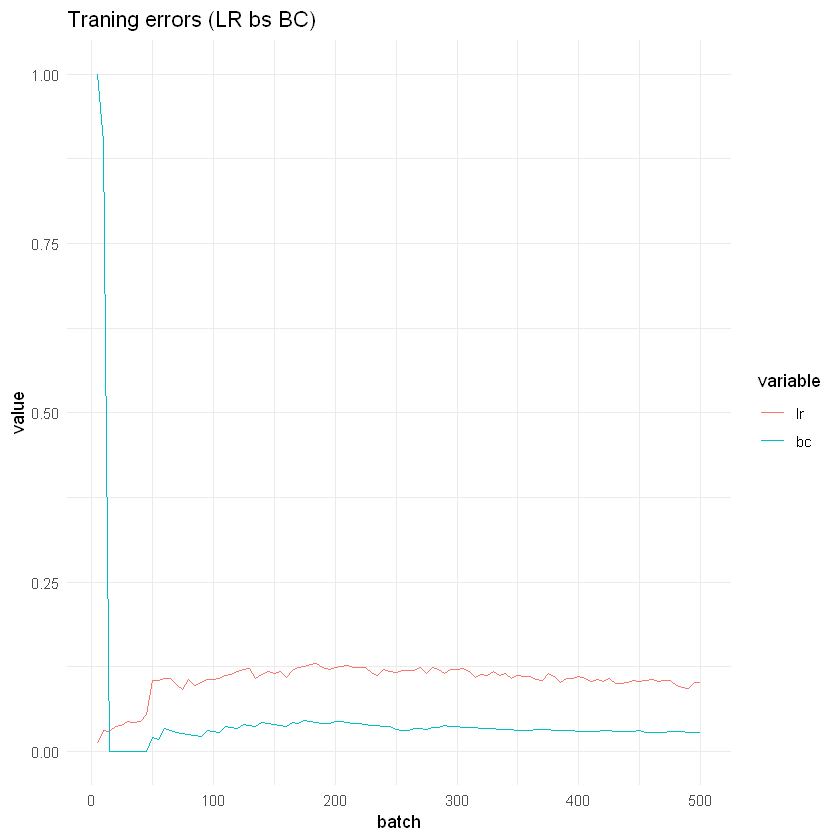

In [8]:
train_errors_m = melt(train_errors, id='batch')
plot = ggplot(data=train_errors_m, aes(x=batch, y=value, color=variable)) + 
       geom_line() + 
       theme_minimal() + 
       ggtitle("Traning errors (LR bs BC)")
plot

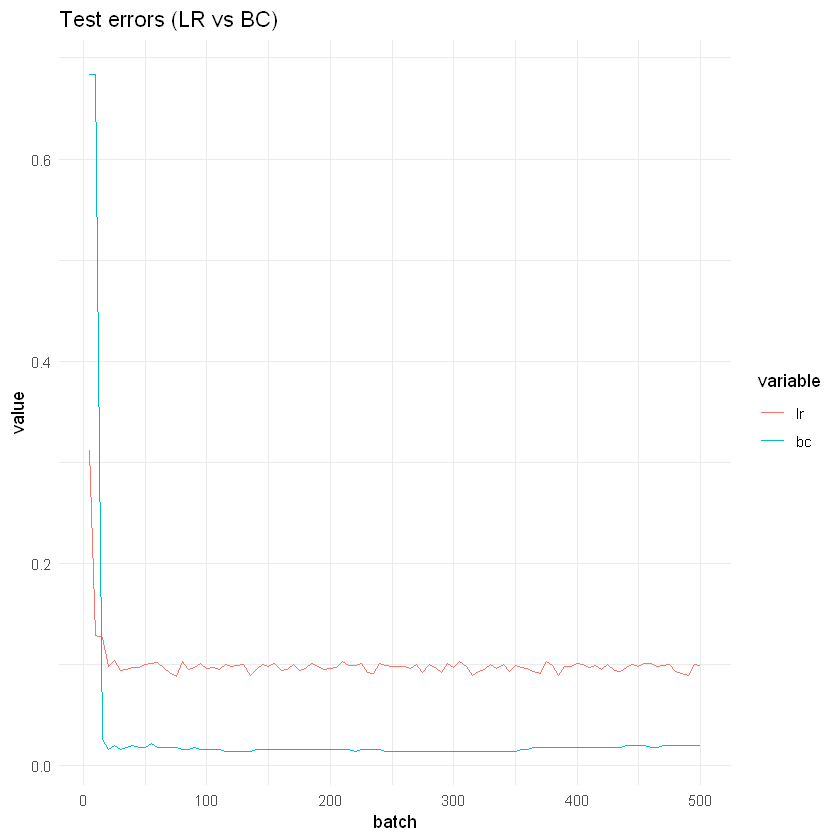

In [9]:
test_errors_m = melt(test_errors, id='batch')
plot = ggplot(data=test_errors_m, aes(x=batch, y=value, color=variable)) + 
       geom_line() + 
       theme_minimal() + 
       ggtitle("Test errors (LR vs BC)")
plot

### 7.3
##### Explain your observations in your Jupyter Notebook file.:
###### a. What does happen for each classifier when the number of training data points is increased?

###### b. Which classifier is best suited when the training set is small, and which is best suited when the training set is big?

###### c. Justify your observations in previous questions (III.a & III.b) by providing some speculations and possible reasons.

#### Answer:

##### a. As the number of training data points  increases, the model more tries to fit well. But for the baysian classifier, it generalises well on smaller data points.
##### b. Therefore, the Baysian classifier is more suited to train on smaller dataset whereas linear regression is more suited for larger dataset.
##### c. Baysianclassifier is a generative model, which can generalise well given smaller dataset. That is why even with smaller data it shows better performance. That performance remains constant even if the data size increases. For the linear regression, with more examples it can well define the decision boundary and is able to separate the data well. 